# Mammography segmentation solutions with Machine Learning

## Dataset

### EMBED
EMmory brEast Imagin Dataset (EMBED): https://registry.opendata.aws/emory-breast-imaging-dataset-embed/


## Breast Calcification

Throughout discription:
https://www.breastcancer.org/screening-testing/mammograms/calcifications

### Defining variables that are used in every part of the code

In [2]:
import pandas as pd
import numpy as np

In [3]:
data_path = '/home/szelesteya/projects/EMBED_Open_Data/'
tables_path = data_path + 'tables/'
image_dest_path = '/media/szelesteya/F824D4D024D492CC/EMBED-images/all-calc-with-roi-reduced'

### Examine labels and pulling down the neccessary images

Only run these lines once, because it may take long time

#### Type of calcification labels

In [4]:
legends = pd.read_csv(tables_path + 'AWS_Open_Data_Clinical_Legend.csv')

calc_findings_codes = (legends[legends['Header in export'].str.contains('calcfind')])[['Meaning','Code']].values
calc_distrib_codes = (legends[legends['Header in export'].str.contains('calcdistri')])[['Meaning','Code']].values

## Possible calcification findings and it's codes
print(calc_findings_codes)

## Possible calcification distribution types and it's codes
print(calc_distrib_codes)

[['Amorphous' 'A']
 ['Benign' '9']
 ['Coarse heterogeneous' 'H']
 ['Course Popcorn-like' 'C']
 ['Dystrophic' 'D']
 ['Rim' 'E']
 ['Fine-linear (casting)' 'F']
 ['Fine linear-branching (casting)' 'B']
 ['Generic' 'G']
 ['Fine pleomorphic' 'I']
 ['Large Rodlike' 'L']
 ['Milk of calcium' 'M']
 ['Oil Cyst' 'J']
 ['Pleomorphic' 'K']
 ['Punctate' 'P']
 ['Round' 'R']
 ['Skin' 'S']
 ['Lucent-centered' 'O']
 ['Suture' 'U']
 ['Vascular' 'V']
 ['Coarse' 'Q']]
[['Grouped' 'G']
 ['Segmental' 'S']
 ['Regional' 'R']
 ['Diffuse/scattered' 'D']
 ['Linear' 'L']
 ['Clustered' 'C']]


#### Find the calcification findings in the clinical data table

In [5]:
data = pd.read_csv(tables_path + 'EMBED_OpenData_clinical.csv', low_memory=False)

records_with_calc_finding = (data[data['calcfind'].notna() | data['calcdistri'].notna()])[['Unnamed: 0','empi_anon','acc_anon','side','calcfind','calcdistri','otherfind','numfind','path_severity']]

print(records_with_calc_finding)

       Unnamed: 0  empi_anon          acc_anon side calcfind calcdistri  \
3             128   43734324  1878527667143380    R        G        NaN   
8             141   76460806  4967580529575444    R        P          G   
15            167   69002034  1080533575112798    L        Q        NaN   
16            169   15411388  2042050676889019    L      A,M          R   
22            194   94981297  5029965028297796    L        I          C   
...           ...        ...               ...  ...      ...        ...   
81760       85701   41216370  9987717412533391    R        G        NaN   
81761       85702   41216370  9987717412533391    R        G        NaN   
81764       85707   93869302  9832248116139404    R        P          G   
81765       85708   93869302  5208318985884426    R        G        NaN   
81772       85721   87435182  8888135176218475    R        R        NaN   

      otherfind  numfind  path_severity  
3           NaN        1            2.0  
8           NaN

#### Find the pictures containing ROI information and no special view then merge it with the calcification findings

In [6]:
metadata = (pd.read_csv(tables_path + 'EMBED_OpenData_metadata_reduced.csv', low_memory=False))

metadata_with_ROI = metadata[(metadata['ROI_coords'].str.contains('\d', regex=True) & (metadata['spot_mag'] != 1.0))]

records_with_calc_finding = records_with_calc_finding.rename(columns={'side':'ImageLateralityFinal'})
records_with_calc_finding_path = pd.merge(records_with_calc_finding, metadata_with_ROI, on=['empi_anon','acc_anon','ImageLateralityFinal'])

records_with_calc_finding_path_reduced = records_with_calc_finding_path[['empi_anon','acc_anon','anon_dicom_path','ImageLateralityFinal','ROI_coords','calcfind','calcdistri', 'spot_mag']].copy()

records_with_calc_finding_path_reduced.loc[:, 'relative_dcm_path'] = records_with_calc_finding_path_reduced['anon_dicom_path'].copy()
records_with_calc_finding_path_reduced.loc[:, 'relative_dcm_path'] = records_with_calc_finding_path_reduced['relative_dcm_path'].str.split('/')
records_with_calc_finding_path_reduced.loc[:, 'relative_dcm_path'] = records_with_calc_finding_path_reduced['relative_dcm_path'].apply(lambda x: '/'.join(x[7:]))

with open(data_path + 'calc_findings_path.csv', 'w') as f:
    (records_with_calc_finding_path_reduced[['anon_dicom_path']]).to_csv(f, index=False)

with open(data_path + 'calc_findings_full.csv', 'w') as f:
    (records_with_calc_finding_path_reduced).to_csv(f, index=False)

# print(records_with_calc_finding_path_reduced)

#### Pulling the images using aws

In [7]:
%%bash -s "$image_dest_path" "{data_path}calc_findings_path.csv"

dcm_dest_path="$1"
dcm_paths="$2"

tail -n +2 $dcm_paths | while IFS= read -r line; do
    relative_path=$(echo "$line" | cut -d '/' -f 6- | awk -v OFS='/' '{$1=$1; print}')
    dcm_name=$(echo "$relative_path" | cut -d '/' -f 3-)

    # echo "s3://embed-dataset-open/images/$relative_path"
    # aws s3 cp "s3://embed-dataset-open/images/$relative_path" "${dcm_dest_path}/$dcm_name" --profile my-dev-profile
done

#### Convert dcm to png (with the code of the EMBED repository)

In [7]:
import pydicom
import numpy as np
import pandas as pd
import png
from pathlib import Path

In [8]:
# Variables
image_path = image_dest_path + '-png/'

In [9]:
# Get DICOM image metadata
class DCM_Tags():
    def __init__(self, img_dcm):
        try:
            self.laterality = img_dcm.ImageLaterality
        except AttributeError:
            self.laterality = np.nan
            
        try:
            self.view = img_dcm.ViewPosition
        except AttributeError:
            self.view = np.nan
            
        try:
            self.orientation = img_dcm.PatientOrientation
        except AttributeError:
            self.orientation = np.nan

# Check whether DICOM should be flipped
def check_dcm(imgdcm):
    # Get DICOM metadata
    tags = DCM_Tags(imgdcm)
    
    # If image orientation tag is defined
    if ~pd.isnull(tags.orientation):
        # CC view
        if tags.view == 'CC':
            if tags.orientation[0] == 'P':
                flipHorz = True
            else:
                flipHorz = False
            
            if (tags.laterality == 'L') & (tags.orientation[1] == 'L'):
                flipVert = True
            elif (tags.laterality == 'R') & (tags.orientation[1] == 'R'):
                flipVert = True
            else:
                flipVert = False
        
        # MLO or ML views
        elif (tags.view == 'MLO') | (tags.view == 'ML'):
            if tags.orientation[0] == 'P':
                flipHorz = True
            else:
                flipHorz = False
            
            if (tags.laterality == 'L') & ((tags.orientation[1] == 'H') | (tags.orientation[1] == 'HL')):
                flipVert = True
            elif (tags.laterality == 'R') & ((tags.orientation[1] == 'H') | (tags.orientation[1] == 'HR')):
                flipVert = True
            else:
                flipVert = False
        
        # Unrecognized view
        else:
            flipHorz = False
            flipVert = False
            
    # If image orientation tag is undefined
    else:
        # Flip RCC, RML, and RMLO images
        if (tags.laterality == 'R') & ((tags.view == 'CC') | (tags.view == 'ML') | (tags.view == 'MLO')):
            flipHorz = True
            flipVert = False
        else:
            flipHorz = False
            flipVert = False
            
    return flipHorz, flipVert

# Save DICOM pixel array as PNG
def save_dcm_image_as_png(image, png_filename, bitdepth=12):
    with open(png_filename, 'wb') as f:
        writer = png.Writer(height=image.shape[0], 
                            width=image.shape[1], 
                            bitdepth=bitdepth, 
                            greyscale=True)
        writer.write(f, image.tolist())

In [10]:
def generate_png_path(dcm_path):
    # Get new file name
    split_fn = dcm_path[:-4].split('/')
    new_fn = f"{split_fn[-1]}_conv.png"
    return image_path + new_fn

In [11]:
# Convert list of DICOMs to PNGs
def process_dcm_list(findings_df):
    dcm_list = findings_df['full_dcm_path']
    png_list = findings_df['full_png_path']
    
    for i, dcm_path in enumerate(dcm_list):    
        if not Path(png_list[i]).exists():
            print(f"Processing DICOM #{i}...")
            
            # Load DICOM
            dcm = pydicom.dcmread(dcm_path)
            img = dcm.pixel_array
            
            # Check if a horizontal flip is necessary
            horz, _ = check_dcm(dcm)
            if horz:
                # Flip img horizontally
                img = np.fliplr(img)
            
            # Save PNG            
            save_dcm_image_as_png(img, png_path)

In [13]:
# Provide a list of DICOM paths and a target directory
dcm_list = []
calc_findings = pd.read_csv(data_path + 'calc_findings_full.csv')

for index, row in calc_findings.iterrows():
    path = image_dest_path  + '/' + row['relative_dcm_path']
    if Path(path).exists():
        dcm_list.append(path)

# Insert dicom path
calc_findings.loc[:,'full_dcm_path'] = dcm_list
    
# Insert png path
calc_findings.loc[:,'full_png_path'] = calc_findings['full_dcm_path'].copy()
calc_findings.loc[:,'full_png_path'] = calc_findings['full_png_path'].apply( lambda x: generate_png_path(x))

with open(data_path + 'calc_findings_full.csv', 'w') as f:
    (calc_findings).to_csv(f, index=False)

# Convert DICOMs
process_dcm_list(calc_findings)

### Examine pictures' intensity and the quality of the ROI 

In [14]:
calc_findings = pd.read_csv(data_path + 'calc_findings_full.csv')

#### Make histogram of the intensities of the pictures

In [21]:
import matplotlib.pyplot as plt
from PIL import Image

In [22]:
def calculate_intensity(pixel_array):
    min = np.min(pixel_array)
    # Drop the part not containing tissues
    pixel_array = pixel_array[(pixel_array > min * 1.5)]
    intensity = np.mean(pixel_array)
    return intensity

In [33]:
def calculate_intensity_of_png(calc_findings):
    intensities_array = []
    png_list = calc_findings['full_png_path'].tolist()
    
    print(f'Calculating intensitiy for {len(png_list)} png image')
    for index in range(len(png_list)):
        print(f'{index + 1} / {len(png_list)}\nCalculating intensity for image {png_list[index]}\n...')
        # Get pixel array from dicom path
        image = Image.open(png_list[index])
        if image.mode != 'L':
            image = image.convert('L') 

        pixel_array = np.array(image)
        intensity = calculate_intensity(pixel_array)

        print(f'Intensity is {intensity}\n')
        intensities_array.append(intensity)        

    return intensities_array

Only calculate intensity for each picture if our datatable don't contain it already, because this may take time

In [36]:
## Calculate intensities for each dicom image and append it to the DataFrame this may take a while
intensities_array = None
intensities_array = calculate_intensity_of_png(calc_findings)

Calculating intensitiy for 1960 png image
1 / 1960
Calculating intensity for image /media/szelesteya/F824D4D024D492CC/EMBED-images/all-calc-with-roi-reduced-png/1.2.826.0.1.3680043.8.498.12681424261940133202438074551382227544_conv.png
...
Intensity is 254.7893212202875

2 / 1960
Calculating intensity for image /media/szelesteya/F824D4D024D492CC/EMBED-images/all-calc-with-roi-reduced-png/1.2.826.0.1.3680043.8.498.39167993503878102186225771580782440618_conv.png
...
Intensity is 254.8790693795438

3 / 1960
Calculating intensity for image /media/szelesteya/F824D4D024D492CC/EMBED-images/all-calc-with-roi-reduced-png/1.2.826.0.1.3680043.8.498.10735466440989741668586797439596379519_conv.png
...
Intensity is 254.89734644334294

4 / 1960
Calculating intensity for image /media/szelesteya/F824D4D024D492CC/EMBED-images/all-calc-with-roi-reduced-png/1.2.826.0.1.3680043.8.498.11876851440454397415965504044496659551_conv.png
...
Intensity is 254.94149729754045

5 / 1960
Calculating intensity for image

/home/szelesteya/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/szelesteya/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Intensity is 247.89320530378663

70 / 1960
Calculating intensity for image /media/szelesteya/F824D4D024D492CC/EMBED-images/all-calc-with-roi-reduced-png/1.2.826.0.1.3680043.8.498.11887769598769189362233369157522692723_conv.png
...
Intensity is nan

71 / 1960
Calculating intensity for image /media/szelesteya/F824D4D024D492CC/EMBED-images/all-calc-with-roi-reduced-png/1.2.826.0.1.3680043.8.498.26449089654399782928854206681647854610_conv.png
...
Intensity is 247.89320530378663

72 / 1960
Calculating intensity for image /media/szelesteya/F824D4D024D492CC/EMBED-images/all-calc-with-roi-reduced-png/1.2.826.0.1.3680043.8.498.73936419950422287987965274521422900021_conv.png
...
Intensity is 254.90877202447666

73 / 1960
Calculating intensity for image /media/szelesteya/F824D4D024D492CC/EMBED-images/all-calc-with-roi-reduced-png/1.2.826.0.1.3680043.8.498.15247139002048029753870246270217650196_conv.png
...
Intensity is 254.77862546873018

74 / 1960
Calculating intensity for image /media/szelestey

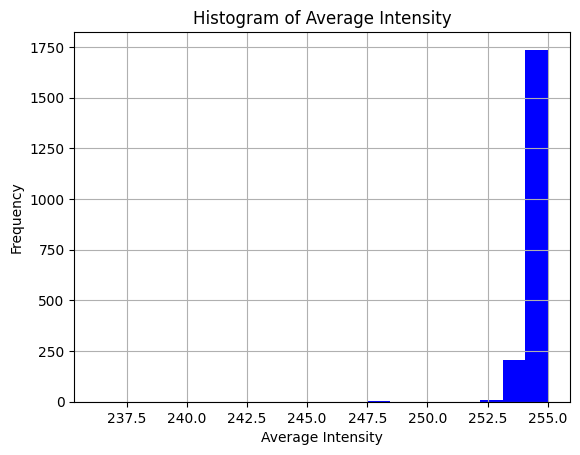

In [37]:
#intensities_cut_array = intensities_array[~(intensities_array > 1000)]

if intensities_array is None:
    intensities_array = calc_findings['intensity'].tolist()

plt.hist(intensities_array, bins=20, color='blue')
plt.xlabel('Average Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Average Intensity')
plt.grid(True)
plt.savefig('avg_intensity_histogram.png')

In [38]:
# Insert intensities in the DataFrame and save the histogram
calc_findings.loc[:,'intensity'] = intensities_array

with open(data_path + 'calc_findings_full.csv', 'w') as f:
    (calc_findings).to_csv(f, index=False)

#### Classifying the calcifications and showcase ROI with minimalistic GUI

In [61]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image

In [11]:
def showcase_ROI(calcfinding_row, save):
    image = Image.open(calcfinding_row['full_png_path'])
    image_array = np.array(image)
        
    path = (calcfinding_row['full_png_path'])[:-4] + '_with_ROI'
    
    only_ROI_arrays = []
    
    # Coordinate(s) of any detected ROI on the image, represented as a list of lists. 
    # Sublists contains corner coordinates for ROI in the format ‘ymin, xmin, ymax, xmax’.
    roi_coords_array = calcfinding_row['ROI_coords'][2:-1].split('(')

    aspect_ratio = image_array.shape[1] / image_array.shape[0]
    fig_all, axis_all = plt.subplots(figsize=(4*aspect_ratio, 4))
    axis_all.imshow(image_array, cmap='gray')
    
    for i in range(len(roi_coords_array)):
        roi_coords_str = roi_coords_array[i].split(')')[0].replace(" ","").split(',')
        roi_coords = [eval(j) for j in roi_coords_str]

        x_min = roi_coords[1]
        y_min = roi_coords[0]
        x_max = roi_coords[3]
        y_max = roi_coords[2]
        
        rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        axis_all.add_patch(rectangle)
        
        only_ROI_arrays.append(image_array[y_min:y_max, x_min:x_max])

    axis_all.set_aspect('equal', adjustable='datalim')
    plt.axis('off')
    if save:
        plt.savefig(path + '_all.png', bbox_inches='tight', pad_inches=0, dpi=300)
    else:
        plt.imshow(image_array, cmap='gray')

    fig, axs = plt.subplots(1, len(only_ROI_arrays), figsize=(15, 5))
    fig.subplots_adjust(wspace=0.1)
    for i in range(len(roi_coords_array)):
        if len(roi_coords_array) > 1:
            axs[i].axis('off')
            axs[i].imshow(only_ROI_arrays[i], cmap='gray')
        else:
            axs.axis('off')
            axs.imshow(only_ROI_arrays[i], cmap='gray')
        
    if save:
        fig.savefig(path + '_rois.png',  bbox_inches='tight', pad_inches=0, dpi=300)

I used a GUI to find images for my purposes more efficiently

In [12]:
import ipywidgets as widgets
from IPython.display import display

In [13]:
value = 0

In [20]:
def on_value_change(num):
    global value
    value = num
    showcase_ROI(calc_findings.loc[value,:], False)        
    print(calc_findings.loc[value,:])

def save_figure(b):
    global value
    with button_output:
        showcase_ROI(calc_findings.loc[value,:], True)

In [21]:
# Create a slider for input
number_slider = widgets.IntSlider(value=1122, min=1, max=1959, description='Number:')

button_save = widgets.Button(description="Save figures")
button_save.on_click(save_figure)

button_output = widgets.Output()

# Create an interactive output that updates when the slider value changes
slider_output = widgets.interactive_output(on_value_change, {'num': number_slider})

# Display the slider and the output
display(number_slider, slider_output)
display(button_save, button_output)

IntSlider(value=1122, description='Number:', max=1959, min=1)

Output()

Button(description='Save figures', style=ButtonStyle())

Output()

### Histogram Equalizations

https://pyimagesearch.com/2021/02/01/opencv-histogram-equalization-and-adaptive-histogram-equalization-clahe/

In [39]:
import cv2 as cv
import os
import imageio.v3 as iio

equalized_img_path = image_dest_path + '-equalized'
clahe_img_path = image_dest_path + '-clahe'
calc_findings = pd.read_csv(data_path + 'calc_findings_full.csv')

#### Histrogram Equalization

In [40]:
def hist_eq(image_source, image_destination):
    img = cv.imread(image_source, cv.IMREAD_GRAYSCALE)
    equ = cv.equalizeHist(img)
    res = np.array(equ)
    cv.imwrite(image_destination, res)

In [41]:
def calculate_intensity_for_png(image_path):
    pixel_array = iio.imread(image_path)
    return calculate_intensity(pixel_array)

In [48]:
calc_findings['equalized_img_path'] = calc_findings['full_png_path']
calc_findings['intensity_after_eq'] = calc_findings['intensity']
intensity_array = []

for i in range(len(calc_findings.loc[::10, 'full_png_path'])):
    dest = equalized_img_path + f'/{i*10}.jpg'
    hist_eq(calc_findings.loc[i*10,'full_png_path'], dest)
    calc_findings.loc[i*10,'equalized_img_path'] = dest
    calc_findings.loc[i*10,'intensity_after_eq'] = calculate_intensity_for_png(dest)
    intensity_array.append(calc_findings.loc[i*10,'intensity_after_eq'])
    print(calc_findings.loc[i*10,'intensity_after_eq'])

129.2623689023666
128.16589114581495
128.32032086380298
128.8858847888627
134.20058983151037
128.84812916162718
128.4252327847184
139.44367519124197
130.03001087262564
128.69197078405983
128.5035430499286
128.5156220981639
137.11810126014677
128.26517281326244
135.18344823630946
135.32581163369736
128.9064503937776
128.67814845019433
128.40631016424553
128.14547119413118
128.73764636902231
128.29492938408964
128.0849655426617
128.6459709893809
128.72159506871856
128.4043034432444
134.80041486507568
129.33806469299722
128.21668569635085
128.59131425753694
128.75088266534885
128.444004236579
134.59153305425014
135.67425284587975
128.31835402294507
128.61989841088268
133.66243542694772
128.59821364298227
128.7350037193874
128.707310114464
135.80059331620225
128.88039789890456
138.09983091058632
128.832993085792
128.3575159433071
128.88675369117985
128.21714038797816
128.41097294332218
136.73330619195403
128.61257700001877
134.82641196474898
128.33973596461922
138.7911488894065
128.4944787

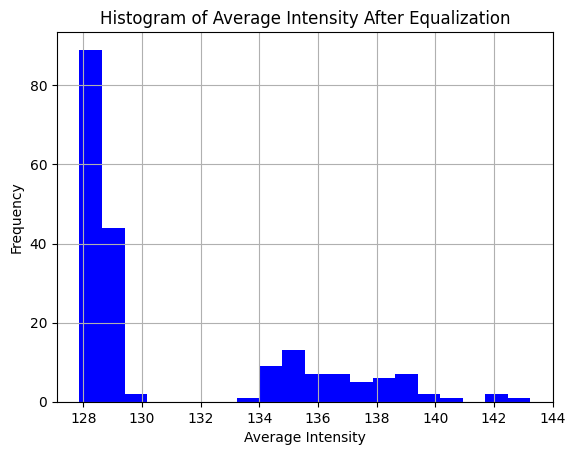

In [43]:
plt.hist(intensity_array, bins=20, color='blue')
plt.xlabel('Average Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Average Intensity After Equalization')
plt.grid(True)
plt.savefig('avg_intensity_equalized_histogram.png')

#### Adaptive Histogram Equalization (CLAHE)

In [44]:
def clahe_image(image_source, image_destination):
    image = cv.imread(image_source)
    image_grey = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    clahe = cv.createCLAHE(clipLimit=5)
    final_img = clahe.apply(image_grey)
    cv.imwrite(image_destination, final_img)

In [52]:
calc_findings['clahe_img_path'] = calc_findings['full_png_path']
calc_findings['intensity_after_clahe'] = calc_findings['intensity']
intensity_array = []

for i in range(len(calc_findings.loc[:, 'full_png_path'])):
    dest = clahe_img_path + f'/{i}.jpg'
    clahe_image(calc_findings.loc[i,'full_png_path'], dest)
    calc_findings.loc[i,'clahe_img_path'] = dest
    calc_findings.loc[i,'intensity_after_clahe'] = calculate_intensity_for_png(dest)
    intensity_array.append(calc_findings.loc[i,'intensity_after_clahe'])
    print(calc_findings.loc[i,'intensity_after_clahe'])

58.07888344172556
55.23287588921856
41.11821709152548
51.975983086569045
39.592774736844085
32.919239678303946
41.97448537805466
40.24259746663066
62.993653803068156
35.878100661226284
24.697093214558098
34.60290032295598
24.323845261156368
51.05742096303029
42.40242779900749
43.0187780104105
36.96645112290338
37.28501643862855
50.723355750304016
49.89824363739537
37.124914414565104
50.6891775518862
39.48497562073882
51.89936272272789
59.943313103230466
35.36872086135283
18.63119984861807
46.75287974895074
23.49040007520157
57.197298899144485
46.83448043885988
46.34233756914983
41.49590973128839
54.22694736960743
46.20663854483304
52.891763271835785
22.434891947922612
25.372901705306983
37.85875696348043
47.2860753970697
22.434891947922612
25.372901705306983
37.85875696348043
47.2860753970697
63.48461562281423
30.2726226303483
54.202108308375415
26.65856075103662
63.48461562281423
30.2726226303483
54.202108308375415
26.65856075103662
38.91717813871521
38.91717813871521
38.9171781387152

TypeError: Can't convert object to 'str' for 'filename'

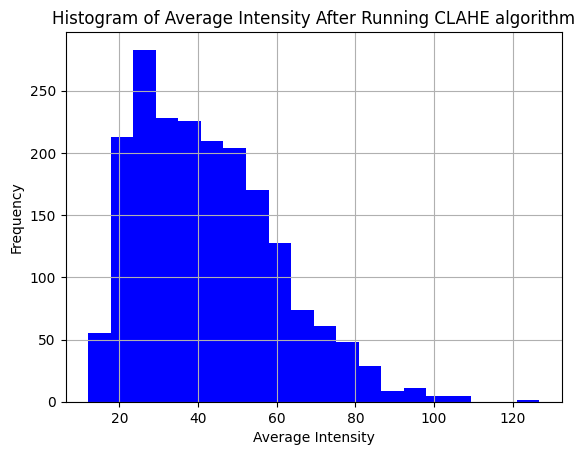

In [53]:
plt.hist(intensity_array, bins=20, color='blue')
plt.xlabel('Average Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Average Intensity After Running CLAHE algorithm')
plt.grid(True)
plt.savefig('avg_intensity_clahe_histogram.png')

Saving the path of new images and intensities

In [54]:
with open(data_path + 'calc_findings_full.csv', 'w') as f:
    (calc_findings).to_csv(f, index=False)

### Adding negative result to the dataset